In [1]:
%%capture
pip install fa2_modified

In [2]:
%%capture
pip install powerlaw

In [3]:
import ast
from fa2_modified import ForceAtlas2
from itertools import combinations
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw
import random
import re
from statistics import mean, median, mode
from tqdm import tqdm
import urllib.request

# The Data

The data used in this graph is comprised of 3 _.csv_-files:

- _TMDB\_scraped\_features.csv_ (7.1 Mb)
- _TMDB\_scraped\_actors.csv_ (10.1 Mb)
- _WIKI\_scraped\_pages.csv_ (119 Mb)

### Downloading the data of the network

In [4]:
# Loacte the data files in folder
TMDB_SCRAPED_FEATURES_PATH = os.path.join(os.path.abspath(""), "TMDB_scraped_features.csv")
TMDB_SCRAPED_ACTORS_PATH = os.path.join(os.path.abspath(""), "TMDB_scraped_actors.csv")
WIKI_SCRAPED_PAGES_PATH = os.path.join(os.path.abspath(""), "WIKI_scraped_pages.csv")

# Print paths
print(TMDB_SCRAPED_FEATURES_PATH)
print(TMDB_SCRAPED_ACTORS_PATH)
print(WIKI_SCRAPED_PAGES_PATH)

/home/aleksandar-lukic/school/02805_Final_project/code/TMDB_scraped_features.csv
/home/aleksandar-lukic/school/02805_Final_project/code/TMDB_scraped_actors.csv
/home/aleksandar-lukic/school/02805_Final_project/code/WIKI_scraped_pages.csv


In [5]:
# Create DataFrames from csv-files
features_df = pd.read_csv(TMDB_SCRAPED_FEATURES_PATH)
actors_df = pd.read_csv(TMDB_SCRAPED_ACTORS_PATH)
wiki_df = pd.read_csv(WIKI_SCRAPED_PAGES_PATH)

Here are some examples to show the content of the DataFrames:

### Features DataFrame

In [6]:
features_df.head(1)

,feature_id,title,original_language,overview,cast,feature_popularity,vote_count,vote_average,release_date,genre_ids,poster_path,backdrop_path,adult,page,wikidata_id
0,278,The Shawshank Redemption,en,Imprisoned in the 1940s for the double murder ...,"[192, 504, 2141, 2555, 4029, 5063, 6573, 6574,...",180.106,27250,8.7,1994-09-23,"[18, 80]",/9cqNxx0GxF0bflZmeSMuL5tnGzr.jpg,/zfbjgQE1uSd9wiPTX4VzsLi0rGG.jpg,False,1,Q172241


Since the features will be used to create edges/links in a network later on, it is crucial that every feature has a cast, staring at least two actors. 

Thus, the dataframe is cleaned, just in case.

In [7]:
features_df_old = features_df

In [8]:
features_df = features_df.dropna(subset=["cast"])
features_df = features_df[features_df["cast"].apply(len) >= 2]

print(f"Before cleaning: {features_df_old.shape}")
print(f"After cleaning : {features_df.shape}")

Before cleaning: (9750, 15)
After cleaning : (9735, 15)


### Actors example

In [9]:
print(f"The actors_df contains:\n{actors_df.shape[0]} rows\n{actors_df.shape[1]} columns")

The actors_df contains:
188378 rows
6 columns


In [10]:
actors_df.head(1)

,actor_id,original_name,actor_popularity,gender,adult,profile_image_path
0,1,George Lucas,16.91,2,False,/WCSZzWdtPmdRxH9LUCVi2JPCSJ.jpg


### Wikipedia example

In [11]:
print(f"The wiki_df contains:\n{wiki_df.shape[0]} rows\n{wiki_df.shape[1]} columns")

The wiki_df contains:
9438 rows
6 columns


In [12]:
wiki_df.head(1)

,feature_id,title,url,page_content,content_size,wikidata_id
0,2,Ariel,https://en.wikipedia.org/wiki/Ariel_(film),Ariel is a 1988 Finnish drama film directed an...,3346,Q658627


# The Actor Network

The Actor network is generated from: 

In [13]:
# Initialize a NetworkX MultiGraph to store the Actor-network
G = nx.MultiGraph()

## Adding the Actors as Nodes

In [14]:
# Traverse the actors dataframe and 
# add each row as a node with attributes
progress_bar = tqdm(actors_df.iterrows(), total=len(actors_df), desc="Generating nodes in network")

for idx, row in progress_bar:
    node_id = int(row["actor_id"])
    #attributes = row.drop('actor_id').to_dict()
    actor_attributes = {
        "original_name": row["original_name"]
    }
    G.add_node(node_id, **actor_attributes)

Generating nodes in network: 100%|████| 188378/188378 [00:02<00:00, 81705.60it/s]


In [15]:
print("Nodes:", len(G.nodes()))

Nodes: 188378


## Adding the Features as Edges

In [16]:
# Traverse the features dataframe and 
# add for each row, edges between any 
# two actors in the cast list.

# MAX_CAST_SIZE = 50

progress_bar = tqdm(features_df.iterrows(), total=len(features_df), desc="Generating edges in network")

for idx, row in progress_bar:
    
    # Load movie's cast list
    actor_ids = row["cast"]
    
    # Convert the str to a list of int
    actor_ids = ast.literal_eval(actor_ids)
        
#     if len(actor_ids) > MAX_CAST_SIZE:
#         actor_ids = actor_ids[:MAX_CAST_SIZE]
    
    # Get movie data to store in edge
    feature_attributes = {"feature_id": row["feature_id"]}
    
    # Create all pairs of actor_ids
    for pair in [(id1, id2) for (id1, id2) in combinations(actor_ids, 2)]:
        G.add_edge(pair[0], pair[1], **feature_attributes)

Generating edges in network: 100%|██████████| 9735/9735 [00:18<00:00, 519.65it/s]


In [17]:
print("Edges:", len(G.edges()))

Edges: 9885783


## Cleaning up a bit

The raw network created from cross-referencing actors starring in the same movie for every movie in the dataset, would contain approx. 190.000 nodes and a whopping 20 mio edges!

Due to computational constraints, using this network would not be a feasible endeavour. 

Therefore, it was neccessary to crop the dataset used in this project.

### Removing self-loops

In [18]:
# Create placeholder for old values
G_copy = G.copy()

# Remove self-loops in order to make the final plot prettier.
G.remove_edges_from(list(nx.selfloop_edges(G)))

# No. of selfloops removed
diff = len(G_copy.edges()) - len(G.edges())

print(f"Removed {diff} self-loops!")

Removed 252 self-loops!


### Removing nodes with too low degree

As there are currently 190.000 nodes, it is advised to remove nodes with limiting added value to the network. These might be nodes, i.e. actors, staring in very few movies, or have not starred along many other actors. 

In [19]:
# sort nodes after degree
G_sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

# Extract degree from nodes and store separately
G_degree_values = [x[1] for x in G_sorted_degree]

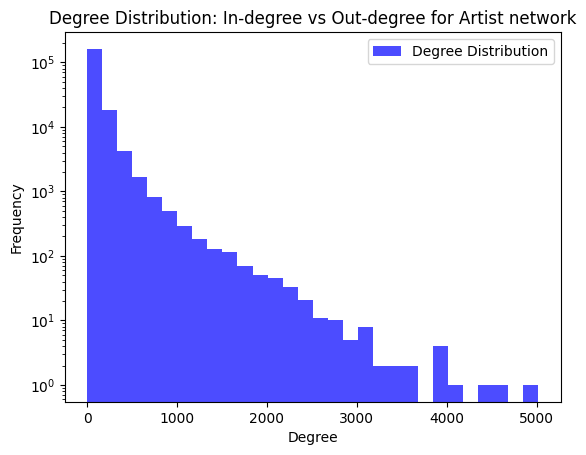

In [20]:
# Histogram of In-degree Distribution
plt.hist(
    G_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Degree Distribution", 
    color="blue"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree vs Out-degree for Artist network")
plt.show()

In [21]:
MIN_DEGREE = 1000

In [22]:
# Identify nodes with a degree less than minimum
nodes_to_remove = [node for node, degree in G.degree() if degree < MIN_DEGREE]

In [23]:
# Remove those nodes
G.remove_nodes_from(nodes_to_remove)

In [24]:
print("G after degree removal:")
print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

G after degree removal:
Nodes: 998
Edges: 89359


### Extract the largest connected component

As a result of the data collection process, the network is inherently fully connected, making the graph equivalent to its largest connected component.

In [25]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create new graph from largest connected component
S = G.subgraph(largest_cc).copy()

In [26]:
print("G->S after extracting LCC:")
print("Nodes:", len(S.nodes()))
print("Edges:", len(S.edges()))

G->S after extracting LCC:
Nodes: 998
Edges: 89359


# Visualizing the network using networkX

In [27]:
# Create ForceAtlas2 configuration
fa2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=4.0,

    # Performance
    jitterTolerance=8.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.1,

    # Log
    verbose=True
    )

In [28]:
# Running the algorithm to get node positions
positions = fa2.forceatlas2_networkx_layout(G, pos=None, iterations=200)

100%|█████████████████████████████████████████| 200/200 [00:01<00:00, 148.27it/s]

BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.69  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.47  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


In [ ]:
# # Extract the 'length_of_content' attribute values
# lengths = nx.get_node_attributes(G, 'length_of_content').values()

# # Normalize these values to range [0, 1] for colormap application
# norm = mcolors.Normalize(vmin=min(lengths), vmax=max(lengths))

# # Choose a colormap; e.g., 'rainbow'
# cmap_ = cm.rainbow

# # Map each node's 'length_of_content' to a color
# node_colors = [cmap_(norm(length)) for length in lengths]

# # Set node sizes based on node degrees (scaled for visibility)
# node_sizes = [G.degree(node) * 3 for node in G.nodes]  # Multiplied by 300 for better scaling


In [ ]:
plt.figure(figsize=(16, 9))

nx.draw(
    G,
    pos=nx.kamada_kawai_layout(G),
    # pos=positions,
    # cmap=cmap_, 
    # node_size=node_sizes,
    # node_color=node_colors,
    alpha=0.5,
    width=0.1,
    edge_color="grey",
    with_labels=False
)

plt.axis('off')

ACTOR_GRAPH_PATH_PDF = os.path.join(os.path.abspath(""), "Actors_network_kkl.pdf")
ACTOR_GRAPH_PATH_PNG = os.path.join(os.path.abspath(""), "Actors_network_kkl.png")
plt.savefig(ACTOR_GRAPH_PATH_PDF, format = "pdf", bbox_inches="tight")
plt.savefig(ACTOR_GRAPH_PATH_PNG, format = "png", bbox_inches="tight")

plt.show()


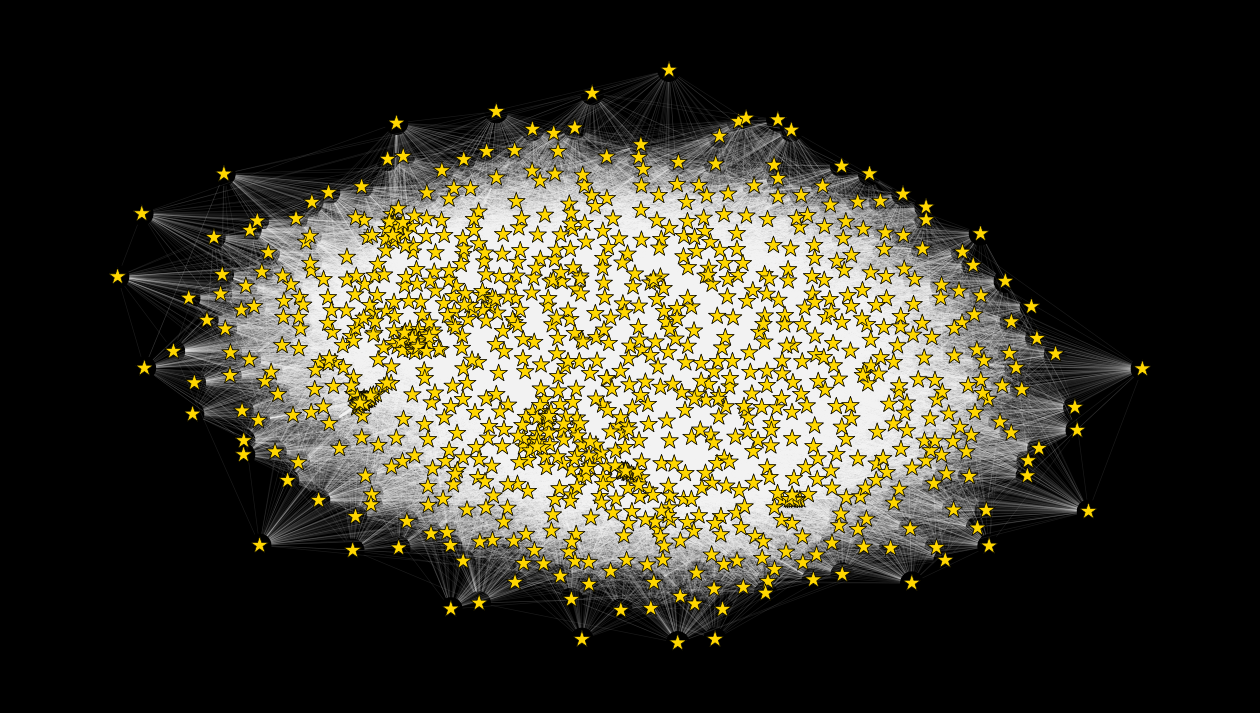

In [32]:
# Visualize the graph
fig, ax = plt.subplots(figsize=(16, 9))

# Draw the nodes without path effects
nodes = nx.draw_networkx_nodes(
    G,
    positions,
    node_shape='*',
    node_size=175,
    node_color='gold',
    edgecolors='black',  # Add a black edge color for the outline
    linewidths=0.5,      # Control the outline thickness
    ax=ax,
)

# Add the stroke effect to the entire node collection
nodes.set_path_effects([
    pe.Stroke(linewidth=0.3, foreground="black"),  # Add black outline
    pe.Normal(),                                  # Normal rendering
])

# Draw the edges
nx.draw_networkx_edges(
    G,
    positions,
    edge_color='white',
    width=0.5,
    alpha=0.1
)

ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')

ACTOR_GRAPH_PATH_PDF = os.path.join(os.path.abspath(""), "Actors_network_fa2.pdf")
ACTOR_GRAPH_PATH_PNG = os.path.join(os.path.abspath(""), "Actors_network_fa2.png")
plt.savefig(ACTOR_GRAPH_PATH_PDF, format = "pdf", bbox_inches="tight")
plt.savefig(ACTOR_GRAPH_PATH_PNG, format = "png", bbox_inches="tight")

plt.show()